### osu!nn #3: momentum estimator

Builds up a model to estimate the momentum - distance over time interval, from the training data.

It might be more accurate to be proportional to circle size, might implement later.

Synthesis of "momentumModel"
* rhythmData x 1
* (Audio) x 1
* (Regressor) x 1

Synthesis Time: ~5 mins

Final edit: 2018/8/16

In [4]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re

In [5]:
root = "mapdata/";

divisor = 4;

max_x = 512;
max_y = 384;

In [6]:
# lst file, [TICK, TIME, NOTE, IS_CIRCLE, IS_SLIDER, IS_SPINNER, IS_SLIDER_END, IS_SPINNER_END, 
#               0,    1,    2,         3,         4,          5,             6,              7,
#            SLIDING, SPINNING, MOMENTUM, ANGULAR_MOMENTUM, EX1, EX2, EX3], length MAPTICKS
#                  8,        9,       10,               11,  12,  13,  14,
# wav file, [len(snapsize), MAPTICKS, 2, fft_size//4]
def read_npz(fn):
    with np.load(fn) as data:
        wav_data = data["wav"];
        wav_data = np.swapaxes(wav_data, 2, 3);
        train_data = wav_data;
        div_source = data["lst"][:, 0];
        div_source2 = data["lst"][:, 12:15];
        div_data = np.concatenate([np.array([[int(k%4==0), int(k%4==1), int(k%4==2), int(k%4==3)] for k in div_source]), div_source2], axis=1);
        lst_data = data["lst"][:, 10:12];
        train_labels = lst_data;
    return train_data, div_data, train_labels;

def read_all_npzs():
    td_list = [];
    dd_list = [];
    tl_list = [];
    for file in os.listdir(root):
        if file.endswith(".npz"):
            _td, _dd, _tl = read_npz(os.path.join(root, file));
            td_list.append(_td);
            dd_list.append(_dd);
            tl_list.append(_tl);
    train_data = np.concatenate(td_list);
    div_data = np.concatenate(dd_list);
    train_labels = np.concatenate(tl_list);
    
    # should be (X, 3, 64, 2) and (X, 6) in default sampling settings
    # (X, fft_window_type, freq_point, magnitude/phase)
    # X = 67142
    # print(train_data.shape, train_labels.shape);
    return train_data, div_data, train_labels;
                
(train_data, div_data, train_labels) = read_all_npzs();

In [7]:
# Normalize training data

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - np.tile(mean, (train_data.shape[0], 1,1,1))) / np.tile(std, (train_data.shape[0], 1,1,1))

# empty_labels = [i for i, label in enumerate(train_labels) if label[0] == 0 and label[1] == 0];
nonempty_labels = np.array([i for i, label in enumerate(train_labels) if (label[0] != 0 or label[1] != 0) and not np.isnan(label[0]) and not np.isnan(label[1]) and label[0] > -10 and label[0] < 10 and label[1] > -10 and label[1] < 10]);


# Remove empty entries

train_data = train_data[nonempty_labels];
div_data = div_data[nonempty_labels];
train_labels = train_labels[nonempty_labels];
train_glob_max = train_labels.max(axis=0);
train_glob_min = train_labels.min(axis=0);
train_labels_normalized = (train_labels - train_glob_min)/(train_glob_max - train_glob_min) * 0.8 * 2 - 1;


The train_glob_max and train_glob_min parameters need to be saved and subsequently used to scale results in momentum prediction.

momentum_predictions_output = momentum_model.predict([test_data2, div_data2]);

momentum_predictions = (momentum_predictions_output.reshape(-1, 2) + 1) / 2 / 0.8 * (train_glob_max - train_glob_min) + train_glob_min;

In [8]:
# Make time intervals from training data
time_interval = 16;
if train_data.shape[0]%time_interval > 0:
    train_data = train_data[:-(train_data.shape[0]%time_interval)];
    div_data = div_data[:-(div_data.shape[0]%time_interval)];
    train_labels = train_labels[:-(train_labels.shape[0]%time_interval)];
    train_labels_normalized = train_labels_normalized[:-(train_labels_normalized.shape[0]%time_interval)];
train_data2 = np.reshape(train_data, (-1, time_interval, train_data.shape[1], train_data.shape[2], train_data.shape[3]))
div_data2 = np.reshape(div_data, (-1, time_interval, div_data.shape[1]))
train_labels2 = np.reshape(train_labels_normalized, (-1, time_interval, train_labels_normalized.shape[1]))

Now build the model.

In [9]:
from tensorflow.keras.models import Model;

def build_model():
    model1 = keras.Sequential([
        keras.layers.TimeDistributed(keras.layers.Conv2D(16, (2, 2),
                           data_format='channels_last'),
                           input_shape=(time_interval, train_data2.shape[2], train_data2.shape[3], train_data2.shape[4])),
        keras.layers.TimeDistributed(keras.layers.MaxPool2D((1, 2),
                           data_format='channels_last')),
        keras.layers.TimeDistributed(keras.layers.Activation(activation=tf.nn.relu)),
        keras.layers.TimeDistributed(keras.layers.Dropout(0.3)),
        keras.layers.TimeDistributed(keras.layers.Conv2D(16, (2, 3),
                           data_format='channels_last')),
        keras.layers.TimeDistributed(keras.layers.MaxPool2D((1, 2),
                           data_format='channels_last')),
        keras.layers.TimeDistributed(keras.layers.Activation(activation=tf.nn.relu)),
        keras.layers.TimeDistributed(keras.layers.Dropout(0.3)),
        keras.layers.TimeDistributed(keras.layers.Flatten()),
        keras.layers.LSTM(64, activation=tf.nn.tanh, return_sequences=True)
    ])
    
    input2 = keras.layers.InputLayer(input_shape=(time_interval, div_data.shape[1]));
    
    conc = keras.layers.concatenate([model1.output, input2.output]);
    dense1 = keras.layers.Dense(71, activation=tf.nn.tanh)(conc);
    dense2 = keras.layers.Dense(71, activation=tf.nn.relu)(dense1);
    dense3 = keras.layers.Dense(2, activation=tf.nn.tanh)(dense2);
    
#     model2 = keras.Sequential([
#         keras.layers.Concatenate(64, activation=tf.nn.tanh),
#         keras.layers.Dense(64, activation=tf.nn.tanh),
#         keras.layers.Dense(64, activation=tf.nn.relu),
#         #    keras.layers.Reshape((4,8)),
#         #    keras.layers.Conv1D(8,2),
#         #    keras.layers.Flatten(),
#         keras.layers.Dense(6, activation=tf.nn.tanh)
#     ])

    optimizer = tf.train.RMSPropOptimizer(0.001);

    
    final_model = Model(inputs=[model1.input, input2.input], outputs=dense3);
    final_model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[keras.metrics.mae])
    return final_model

model = build_model()
model.summary()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Limitless]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train MAE')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val MAE')
    plt.plot(history.epoch, np.array(history.history['loss']), 
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val Loss')
    plt.legend()
    plt.show()

# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_distributed_input (InputLa (None, 16, 7, 32, 2) 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 16, 6, 31, 16 144         time_distributed_input[0][0]     
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 16, 6, 15, 16 0           time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 16, 6, 15, 16 0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distr

ぐるぐる。


........

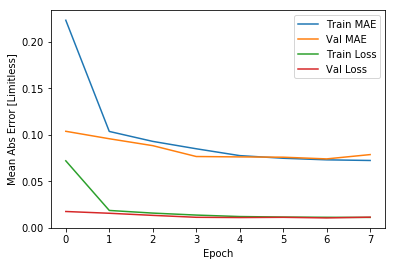


Testing set Mean Abs Error: $  70.10
Mean Abs Error: 0.07010184041583878


In [10]:
EPOCHS = 8

test_split_count = 42

# Split some test data out
new_train_data = train_data2[:-test_split_count];
new_div_data = div_data2[:-test_split_count];
new_train_labels = train_labels2[:-test_split_count];
test_data = train_data2[-test_split_count:];
test_div_data = div_data2[-test_split_count:];
test_labels = train_labels2[-test_split_count:];

# Store training stats
history = model.fit([new_train_data, new_div_data], new_train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0, 
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

[loss, mae] = model.evaluate([test_data, test_div_data], test_labels, verbose=0)

print("\nTesting set Mean Abs Error: ${:7.2f}".format(mae * 1000))

test_predictions = model.predict([test_data, test_div_data]).reshape((-1, time_interval, 2))

# print(test_predictions)
# print(test_labels)
# print(test_predictions - list(test_labels))
print("Mean Abs Error: "+str(np.mean(np.abs(test_predictions - test_labels))))

Save the minmax and the model.

In [11]:
np.save("momentum_minmax", [train_glob_max, train_glob_min]);

tf.keras.models.save_model(
    model,
    "saved_rhythm_model_momentums",
    overwrite=True,
    include_optimizer=True
);

# WARNING:tensorflow:TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer
# state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will
# have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
